In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import multivariate_normal as mvn

In [2]:
data = np.array( [[201, 592, 61],
                  [244, 401, 25],
                  [47, 583, 38],
                  [287, 402, 15],
                  [203, 495, 21],
                  [58, 173, 15],
                  [210, 479, 27],
                  [202, 504, 14],
                  [198, 510, 30],
                  [158, 416, 16],
                  [165, 393, 14],
                  [201, 442, 25],
                  [157, 317, 52],
                  [131, 311, 16],
                  [166, 400, 34],
                  [160, 337, 31],
                  [186, 423, 42],
                  [125, 334, 26],
                  [218, 533, 16],
                  [146, 344, 22]], dtype=np.float32 )

In [3]:
x, y, s = data[:,0],data[:,1],data[:,2]

We'll have to search for parameters $\mathbf{w}$ and $b$ such that:

$y = \mathbf{w}^\mathsf{T}\mathbf{x} + b + \epsilon$

However, we can get rid of the bias term $b$ by appending 1s to the explanatory variables and including $b$ in $\mathbf{w}$:

$
\mathbf{x} \leftarrow [\mathbf{x}, 1] \\
\mathbf{w} \leftarrow [\mathbf{w}, b]
$

In [4]:
ones = np.ones((x.size, 1))
x = np.concatenate( (x.reshape(-1,1), ones), axis=1 )

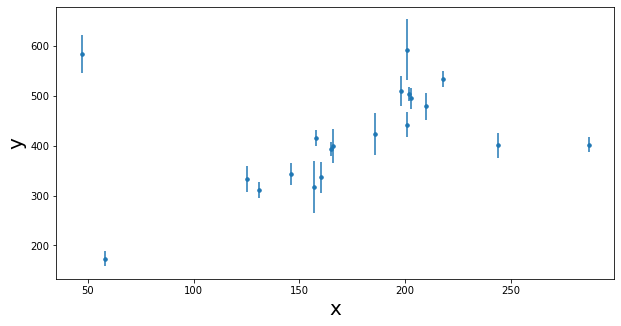

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.errorbar(x[:,0], y, s, None, marker=".",markersize=7, ls='')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.show()

## Oridinary least squares fit

First let's calculate the oridinary least squares fit

We need to minimize a value of $(y - \mathbf{x}\mathbf{w})^\mathsf{T}(y - \mathbf{x}\mathbf{w})$ (residual sum of squares)

The value of it's minimum with respect to $\mathbf{w}$ is $(\mathbf{x}^\mathsf{T}\mathbf{x})^{-1}\mathbf{x}^\mathsf{T}y$

(note that we're not taking the $\epsilon$ into account)

In [6]:
# So now let's create a function that will calculate the minimal value for w and it's respective RSS
def OLS(x, y):
    w = (inv(x.T@x))@x.T@y
    RSS = np.sum((y-x@w).T@(y-x@w))
    return w, RSS 

In [7]:
w, RSS = OLS(x, y)

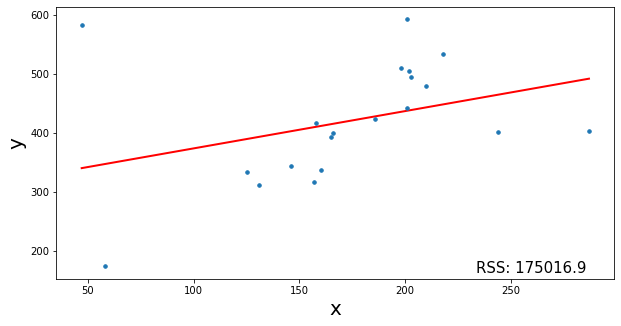

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

xmin, xmax = np.min(x[:, 0]), np.max(x[:, 0])
    
X = np.array([[xmin, 1], [xmax, 1]])
y_ = X @ w

ax.errorbar(x[:,0], y, 0, None, marker=".",markersize=7, ls='')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)

ax.plot(X[:, 0], y_, marker='', lw=2.0, color='r')

ax.text(0.95, 0.01, 'RSS: {0:0.1f}'.format(RSS),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=15)
plt.show()

## Bayesian linear regression

For our prior we'll take normal distribution:

$\mathbf{w} \sim N(\mu_0,\Sigma_0)$

And for the likelyhood we'll use provided data ($\mathbf{x}$ and $y$). The $\sigma$ value (response uncertainty) is a hyperparameter

$y|\mathbf{w} \sim N(\mathbf{x}y,\sigma^2\mathbf{I})$

In [9]:
# known formula
def bayes_lin_reg(pr_mu, pr_Sigma, sigma, x, y):
    post_Sigma = inv(inv(pr_Sigma) + (x.T@x)/(sigma**2))
    post_mu = post_Sigma@(((x.T@y)/(sigma**2)).reshape(-1,1)+inv(pr_Sigma)@pr_mu)
    return post_mu, post_Sigma

In [10]:
# let's create an informative prior
# we can estimate the b value by calculating the mean value of y. y's covariance will be calculated explicitly 

mu_0 = np.array([0, np.mean(y)]).reshape(-1,1)
Sigma_0 = np.array([[1,0],[0,np.var(y)]])

In [11]:
sigma = 25

In [12]:
# post_mu is our MAP(maximum a posteriori) estimated value for w
post_mu, post_Sigma = bayes_lin_reg(mu_0, Sigma_0, sigma, x, y)


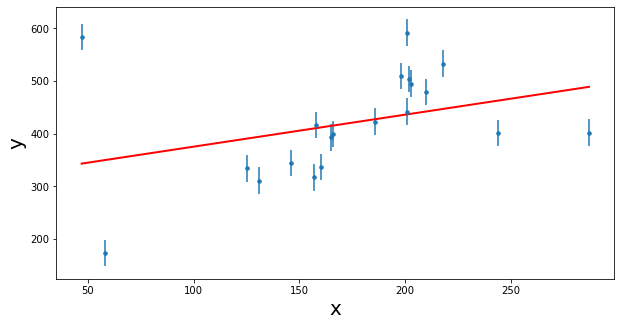

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

xmin, xmax = np.min(x[:, 0]), np.max(x[:, 0])
    
X = np.array([[xmin, 1], [xmax, 1]])
y_ = X @ post_mu

ax.errorbar(x[:,0], y, sigma, None, marker=".",markersize=7, ls='')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)

ax.plot(X[:, 0], y_, marker='', lw=2.0, color='r')
plt.show()

## Let's get some samples from posterior

In [14]:
sigma = 25
post_mu, post_Sigma = bayes_lin_reg(mu_0, Sigma_0, sigma, x, y)

In [15]:
samples = mvn(post_mu.flatten(), post_Sigma).rvs(20)

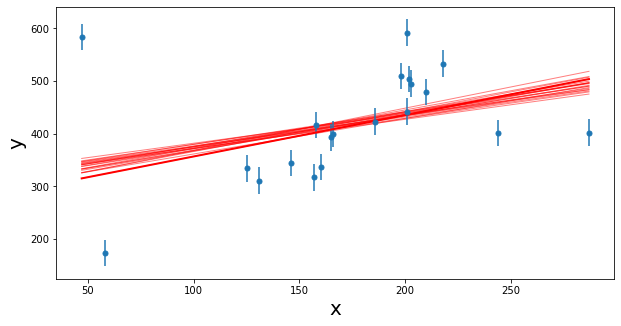

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

xmin, xmax = np.min(x[:, 0]), np.max(x[:, 0])
    
X = np.array([[xmin, 1], [xmax, 1]])
for w_ in samples:
    y_ = X @ w_
    ax.plot(X[:, 0], y_, marker='', lw=1.0, alpha=0.5, color='r');

ax.errorbar(x[:,0], y, sigma, None, marker=".",markersize=10, ls='')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)

ax.plot(X[:, 0], y_, marker='', lw=2.0, color='r')
plt.show()

let's try different $\sigma$

In [17]:
sigma_2 = 100
post_mu, post_Sigma = bayes_lin_reg(mu_0, Sigma_0, sigma_2, x, y)

In [18]:
samples_2 = mvn(post_mu.flatten(), post_Sigma).rvs(20)

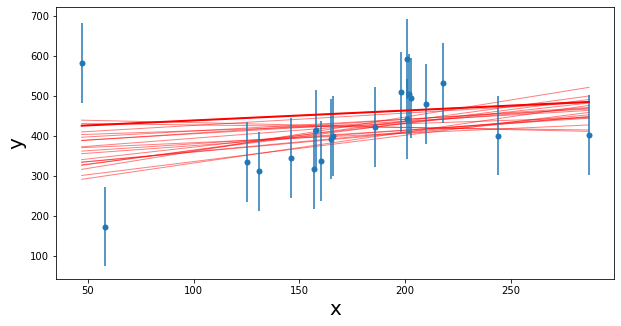

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

xmin, xmax = np.min(x[:, 0]), np.max(x[:, 0])
    
X = np.array([[xmin, 1], [xmax, 1]])
for w_ in samples_2:
    y_ = X @ w_
    ax.plot(X[:, 0], y_, marker='', lw=1.0, alpha=0.5, color='r');

ax.errorbar(x[:,0], y, sigma_2, None, marker=".",markersize=10, ls='')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)

ax.plot(X[:, 0], y_, marker='', lw=2.0, color='r')
plt.show()

## Let's use the posterior to predict new poitns (posterior predictive)

In [20]:
x_ = np.array([[-150, 1],
               [130, 1],
               [280, 1]])

In [21]:
def posterior_predictive(post_mu, post_Sigma, sigma, X):
    mu_pred = post_mu.T @ X
    sigma_pred = np.sqrt(sigma ** 2 + X.T @ post_Sigma @ X)
    return mu_pred, sigma_pred

In [22]:
sigma = 25.
post_mu, post_Sigma = bayes_lin_reg(mu_0, Sigma_0, sigma, x, y)
post_mu, post_Sigma

(array([[  0.60679254],
        [314.71271983]]),
 array([[ 9.96868961e-03, -1.72067613e+00],
        [-1.72067613e+00,  3.28154750e+02]]))

In [23]:
y_mu, y_sigma = np.empty(3), np.empty(3)
for i, x_val in enumerate(x_):
    y_mu[i], y_sigma[i] = posterior_predictive(post_mu, post_Sigma, sigma, x_val)

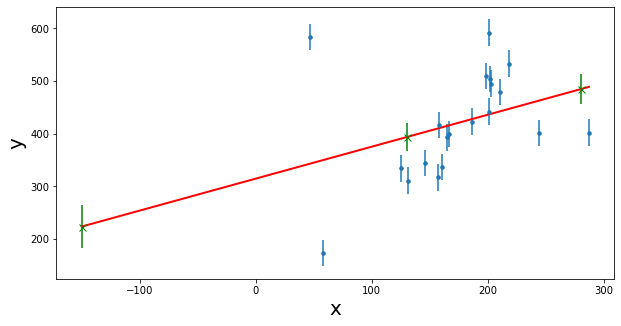

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

xmin = min(np.min(x[:, 0]), np.min(x_[:, 0]))
xmax = max(np.max(x[:, 0]), np.max(x_[:, 0]))
    
X = np.array([[xmin, 1], [xmax, 1]])
y_ = X @ post_mu

ax.errorbar(x[:,0], y, sigma, None, marker=".",markersize=7, ls='')

ax.errorbar(x_[:, 0], y_mu, y_sigma, None, marker="x", c='g', ls='', markersize=7);

ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)

ax.plot(X[:, 0], y_, marker='', lw=2.0, color='r')
plt.show()

In [25]:
y_sigma

array([41.15401687, 25.96632072, 27.76907244])